In [15]:
# Clears previous imports and variable definitions
%reset -f


In [16]:
!pip install torch torchvision scikit-image tqdm

In [18]:
import os
import random
import cv2
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
DATASET_PATH = "/content/drive/MyDrive/CV/gopro_deblur"


In [21]:
class DeblurDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=150):
        self.blur_dir = os.path.join(root_dir, 'blur', 'images')
        self.sharp_dir = os.path.join(root_dir, 'sharp', 'images')

        # Load both PNG and JPG files
        blur_files = sorted(glob(os.path.join(self.blur_dir, '*.png')) + glob(os.path.join(self.blur_dir, '*.jpg')))
        sharp_files = sorted(glob(os.path.join(self.sharp_dir, '*.png')) + glob(os.path.join(self.sharp_dir, '*.jpg')))

        # Ensure matching pairs by filename
        blur_names = [os.path.basename(x) for x in blur_files]
        sharp_names = [os.path.basename(x) for x in sharp_files]
        matched_names = sorted(list(set(blur_names) & set(sharp_names)))

        if len(matched_names) == 0:
            raise ValueError(f"No matching blur/sharp pairs found in {root_dir}")

        # Create full paths for matched pairs
        self.blur_images = [os.path.join(self.blur_dir, n) for n in matched_names]
        self.sharp_images = [os.path.join(self.sharp_dir, n) for n in matched_names]

        # Randomly sample up to num_samples
        random.seed(42)
        num_samples = min(num_samples, len(self.blur_images))
        indices = random.sample(range(len(self.blur_images)), num_samples)
        self.blur_images = [self.blur_images[i] for i in indices]
        self.sharp_images = [self.sharp_images[i] for i in indices]

        self.transform = transform
        print(f"✅ Found {len(self.blur_images)} matching image pairs.")

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        blur = Image.open(self.blur_images[idx]).convert('RGB')
        sharp = Image.open(self.sharp_images[idx]).convert('RGB')
        if self.transform:
            blur = self.transform(blur)
            sharp = self.transform(sharp)
        return blur, sharp


# Define transform + DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = DeblurDataset("/content/drive/MyDrive/CV/gopro_deblur", transform, num_samples=150)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"✅ Dataset ready with {len(dataset)} paired images.")


✅ Found 150 matching image pairs.
✅ Dataset ready with 150 paired images.


In [22]:
# =====================================================
# 5. Define U-Net Model
# =====================================================
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(nn.MaxPool2d(2), CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(nn.MaxPool2d(2), CBR(128, 256), CBR(256, 256))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2), CBR(256, 512), CBR(512, 512))

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        b = self.bottleneck(e3)
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return torch.sigmoid(self.final(d1))


In [23]:
# =====================================================
# 6. Training Setup
# =====================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20

In [24]:
# =====================================================
# 7. Training Loop
# =====================================================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for blur, sharp in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        blur, sharp = blur.to(device), sharp.to(device)
        optimizer.zero_grad()
        output = model(blur)
        loss = criterion(output, sharp)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss/len(dataloader):.4f}")

# Save model
SAVE_PATH = "/content/drive/MyDrive/CV/unet_deblur.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Training complete. Model saved to: {SAVE_PATH}")


Epoch 1/20: 100%|██████████| 38/38 [03:06<00:00,  4.91s/it]


Epoch [1/20] Loss: 0.0757


Epoch 2/20: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Epoch [2/20] Loss: 0.0473


Epoch 3/20: 100%|██████████| 38/38 [00:19<00:00,  1.93it/s]


Epoch [3/20] Loss: 0.0429


Epoch 4/20: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Epoch [4/20] Loss: 0.0432


Epoch 5/20: 100%|██████████| 38/38 [00:19<00:00,  1.90it/s]


Epoch [5/20] Loss: 0.0418


Epoch 6/20: 100%|██████████| 38/38 [00:19<00:00,  1.99it/s]


Epoch [6/20] Loss: 0.0386


Epoch 7/20: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s]


Epoch [7/20] Loss: 0.0398


Epoch 8/20: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s]


Epoch [8/20] Loss: 0.0397


Epoch 9/20: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Epoch [9/20] Loss: 0.0375


Epoch 10/20: 100%|██████████| 38/38 [00:19<00:00,  1.96it/s]


Epoch [10/20] Loss: 0.0358


Epoch 11/20: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s]


Epoch [11/20] Loss: 0.0360


Epoch 12/20: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s]


Epoch [12/20] Loss: 0.0352


Epoch 13/20: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Epoch [13/20] Loss: 0.0354


Epoch 14/20: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s]


Epoch [14/20] Loss: 0.0357


Epoch 15/20: 100%|██████████| 38/38 [00:19<00:00,  1.92it/s]


Epoch [15/20] Loss: 0.0381


Epoch 16/20: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Epoch [16/20] Loss: 0.0343


Epoch 17/20: 100%|██████████| 38/38 [00:19<00:00,  1.92it/s]


Epoch [17/20] Loss: 0.0346


Epoch 18/20: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s]


Epoch [18/20] Loss: 0.0359


Epoch 19/20: 100%|██████████| 38/38 [00:20<00:00,  1.87it/s]


Epoch [19/20] Loss: 0.0327


Epoch 20/20: 100%|██████████| 38/38 [00:19<00:00,  1.99it/s]

Epoch [20/20] Loss: 0.0339
✅ Training complete. Model saved to: /content/drive/MyDrive/CV/unet_deblur.pth


In [26]:
# =====================================================
# 8. Evaluation (PSNR + SSIM)
# =====================================================
model.eval()
blur, sharp = next(iter(dataloader))
with torch.no_grad():
    pred = model(blur.to(device)).cpu()

# Convert tensors to NumPy arrays
blur_np = np.transpose(blur[0].numpy(), (1, 2, 0))
sharp_np = np.transpose(sharp[0].numpy(), (1, 2, 0))
pred_np = np.transpose(pred[0].numpy(), (1, 2, 0))

# Compute metrics with correct data range
psnr = peak_signal_noise_ratio(sharp_np, pred_np, data_range=1.0)
ssim = structural_similarity(sharp_np, pred_np, channel_axis=2, data_range=1.0)

print(f"📈 PSNR: {psnr:.2f} dB | SSIM: {ssim:.3f}")


📈 PSNR: 32.19 dB | SSIM: 0.963


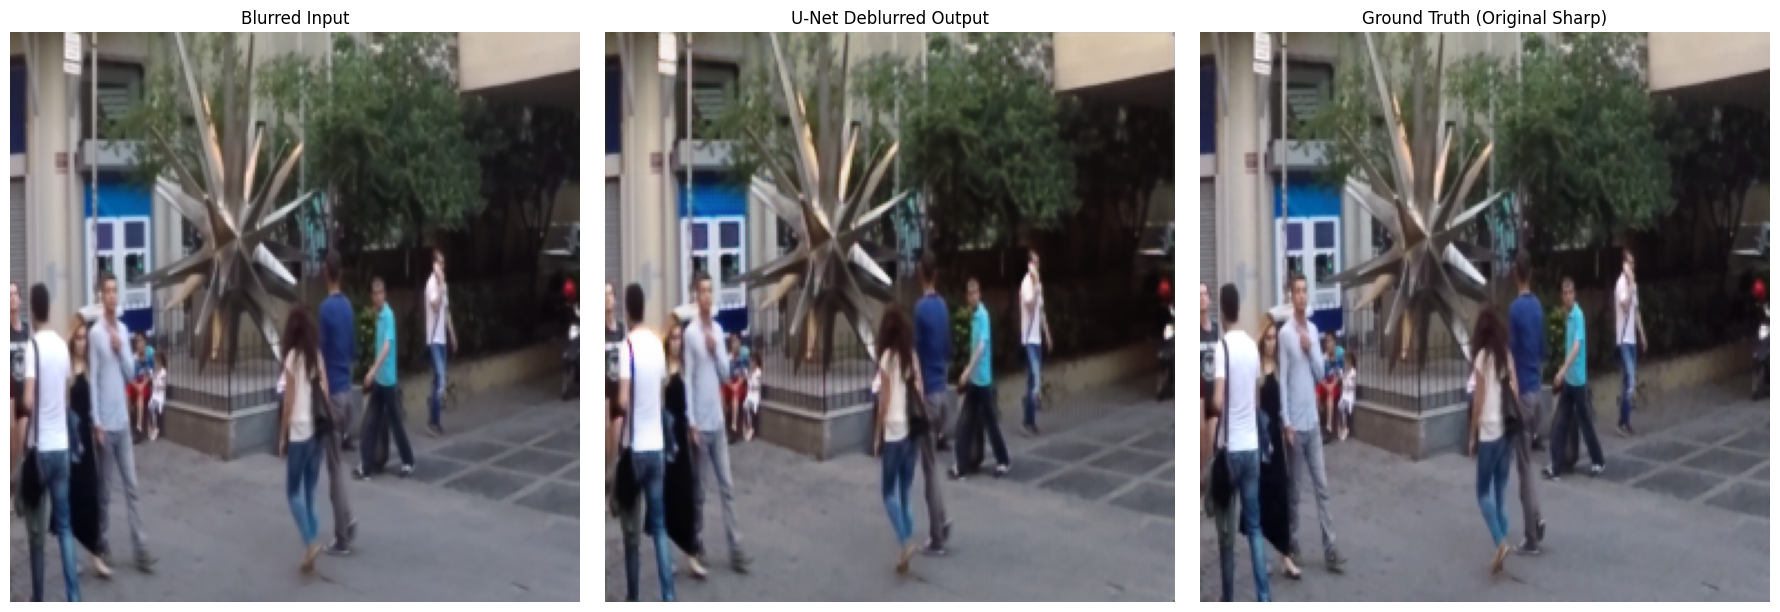

✅ Comparison image saved to: /content/drive/MyDrive/CV/deblur_comparison.png


In [29]:


# Convert tensors to displayable images (0–255 uint8)
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    return img

# Take first sample from batch
blur_img = tensor_to_image(blur[0])
sharp_img = tensor_to_image(sharp[0])
pred_img = tensor_to_image(pred[0])

# Show side-by-side comparison
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(blur_img)
plt.title('Blurred Input')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pred_img)
plt.title('U-Net Deblurred Output')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sharp_img)
plt.title('Ground Truth (Original Sharp)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: save the comparison image to Drive
comparison_path = "/content/drive/MyDrive/CV/deblur_comparison.png"
combined = np.hstack((blur_img, pred_img, sharp_img))
cv2.imwrite(comparison_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
print(f"✅ Comparison image saved to: {comparison_path}")
